#### Before start web scraping we have examined the web page with the instrument 'inspects'. As we see all the information are inside the HTML class 'listing-item_body--content'; we have built our script finding all '<li' class element inside the previous class which contain all the required data.

![](https://github.com/DanSan23/HOMEWORK-4-immobiliare.it/blob/master/Image/Web%20site%20structure.jpg?raw=true)

#### Import library

In [12]:
import requests
import pandas as pd
import math
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize
import numpy as np
import time
from sklearn.cluster import KMeans
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from collections import Counter
% matplotlib inline


ModuleNotFoundError: No module named 'wordcloud'

## Parsing page with BeautifulSoup

Get data from website using $requests$ and $BeautifulSoup$ librabries. Some filters are applied in order to clean data during download.

In [ ]:
#create lists where store the data
title=[]
price=[]
n_room=[]
mq=[]
n_bathroom=[]
plan=[]
desc=[]
i=1
#iterate to take data from different page
for num in tqdm(range(1,1728)):
    url = str('www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag='+str(num))
    r = requests.get('https://' +url)
    data = r.text
    soup = BeautifulSoup(data,'html.parser')

    #iterate on the main class which contain all the data 
    for announcement in tqdm(soup.find_all('div', class_='listing-item_body--content')):
        #find all 'li' class which contain the data that we want and store them inside the lists
        feature = announcement.find_all('li')
        #check if we have all the feature required because some announcement are not complete
        if len(feature)>=5:
            #filter words on price
            feature_price = feature[0].text.strip()
            if ('PREZZO SU RICHIESTA' in feature_price )== True:
                break
            elif('%' in feature_price) == True:
                #remove undesired characters
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                #slice in order to take the desired number
                price.append(feature_price[-19:-12])
            else:
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                price.append(feature_price)
            feature_n_room = feature[1].text[0]
            n_room.append(feature_n_room)
            feature_mq = feature[2].text[0:-12].replace('\xa0','')
            mq.append(feature_mq)
            feature_n_bathroom = feature[3].text[0:-5].replace('+','').replace('\xa0','')
            n_bathroom.append(feature_n_bathroom)
            feature_plan = feature[4].text[0:-7].strip()
            #check if there is a character inside plan data, if yes pop last elements 
            if feature_plan.isalpha()==True:
                price.pop()
                n_room.pop()
                mq.pop()
                n_bathroom.pop()
                i+=0

            else:    
                plan.append(feature_plan)

                #find <a element where <href is present
                link=announcement.find('a', href=True)
                #check to solve the problem where the <href didn't have the complete link
                if ('https://' in link['href'])==True:
                    ann=requests.get(link['href'])
                else:
                    ann=requests.get('https://www.immobiliare.it'+link['href'])
                data1 = ann.text
                #create another bs4 element with the objective of taking commplete text from announcement
                soup1 = BeautifulSoup(data1,'html.parser')
                #access to link and take complete text
                a=soup1.find('div', attrs={'role':'contentinfo'}).text.strip()
                desc.append(a)
                title.append('announcement_'+str(i))
                i+=1


    time.sleep(1)

### Load the list

After downloading all data we have saved them in lists. If you want to try the code run the follow cell after download the files (files are stored in folder DATA file in this repository).

In [4]:
with open(r'C:\Users\Daniele\Desktop\liste download\desc', 'rb') as f:
    desc = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\plan', 'rb') as f:
    plan = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\n_bathroom', 'rb') as f:
    n_bathroom = pickle.load(f)
    
with open(r'C:\Users\Daniele\Desktop\liste download\mq', 'rb') as f:
    mq = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\n_room', 'rb') as f:
    n_room = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\price', 'rb') as f:
    price = pickle.load(f) 
    
with open(r'C:\Users\Daniele\Desktop\liste download\title', 'rb') as f:
    title = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\processed_list', 'rb') as f:
    processed_list = pickle.load(f)    

The data are saved in a dictionary and stored in a pandas DataFrame, in this way the first Dataset is created.

In [5]:
table=pd.DataFrame({'Annuncio':title,
                    'Prezzo':price,
                    'Camere':n_room,
                    'Superficie':mq,
                    'Bagni':n_bathroom,
                    'Piano':plan})
#used to remove a \n inside "Piano" coloumn
Information_cluster =table.set_index('Annuncio')
Information_cluster.head()

,Prezzo,Camere,Superficie,Bagni,Piano
Annuncio,,,,,
announcement_1,225000,2,50,1,1
announcement_2,395000,5,130,2,1
announcement_3,3700000,5,250,3,5
announcement_4,850000,5,175,2,5
announcement_5,279000,3,110,1,1


Function to preprocess all text in the announcement is now executed; it's a function which remove punctuation, undesired symbols,doing tokenization and stemming.

In [6]:
def preprocess(text):
    text = text.lower()
    # removing '\n'
    text = text.replace('\\n', ' ')
    # removing punctuation
    tokenizer = regexp_tokenize(text, "[\w\$]+")
    # filter the non stopwords
    filtered = [w for w in tokenizer if not w in stopwords.words('italian')]
    ps = PorterStemmer()
    # removing the stem
    filtered = [ps.stem(word) for word in filtered]
    return filtered

The preprocess function is now excuted for all announcement and the result is store in a list (in Data files folder, there is also this list)

In [ ]:
processed_list=[]
for i in tqdm(desc):
    processed_list.append(preprocess(i))    

To obtain better results the words which appear too many times and the words which compare only in one announcement are eliminated.

In [9]:
#create a list which contain all the words from processed_list
flat_list = [item for sublist in processed_list for item in sublist]
#create a dictionary and store the counter of every words in flat list
count_dict = Counter(flat_list)
#create a list where store the key name of count_dict 
Removing=list(count_dict.keys())
#loop inside Removing list in order to dropp off rare words and most frequently words
for key in Removing:
    if count_dict[key]<2 or count_dict[key]>10000:
        count_dict.pop(key)
#list of word that we want
want=list(count_dict.keys())
#compare processed list with want list to take only wanted word
item_list = [[i for i in e if i in want] for e in processed_list]

Simply checking the number of unique word that we have.

In [10]:
Number_of_words_final = [item for sublist in item_list for item in sublist]
len(list(set(Number_of_words_final)))

15644

The item_list composed by a nested lists of words is converted to a list of strings and then a data frame with word_Id and all text from the announcement processed is created.

In [11]:
#converting to list of strings
Converting=[' '.join(i) for i in item_list]
#generate the wordId
WordId=[int(i) for i in range(1,len(Converting)+1)]
#creating dataframe with wordId and all text from the announcement processed
df1 = pd.DataFrame({'wordId': WordId, 'parole': Converting})

Pandas and numpy are used to compute $Tf-Idf$ in the previous generated dataframe

In [12]:
#Split words inside dataframe and generate count vectors
word_vec = df1.parole.apply(str.split).apply(pd.value_counts).fillna(0)
# Compute term frequencies
tf = word_vec.divide(np.sum(word_vec, axis=1), axis=0)
# Compute inverse document frequencies
idf = np.log10(len(tf) / word_vec[word_vec > 0].count())
# Compute TF-IDF vectors
tfidf = np.multiply(tf, idf.to_frame().T)
#L2 (Euclidean) normalization
l2_norm = np.sum(np.sqrt(tfidf), axis=1)
#Normalized TF-IDF vectors
tfidf_norm = (tfidf.T / l2_norm).T
#store in a dataframe
Description_cluster=pd.DataFrame(tfidf_norm)
#simply replace the names of columns(which are the words coming from the preprocess ) with the required format
word_column=['word_'+str(i) for i in range(1,len(Description_cluster.columns)+1) ]
Description_cluster.columns=word_column
Description_cluster=Description_cluster.set_index(Information_cluster.index)
Description_cluster.head()

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,...,word_15635,word_15636,word_15637,word_15638,word_15639,word_15640,word_15641,word_15642,word_15643,word_15644
Annuncio,,,,,,,,,,,,,,,,,,,,,
announcement_1,0.007807,0.007722,0.00965,0.005134,0.004507,0.005007,0.00495,0.002511,0.00097,0.001892,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement_5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Saving data to csv

In [14]:
Description_cluster.to_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix_TfIdf.csv')
Information_cluster.to_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix.csv')

### Loading data Matrix

In [ ]:
Description_cluster=pd.read_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix_TfIdf.csv')
Description_cluster=Description_cluster.set_index('Annuncio')
Information_cluster=pd.read_csv(r'C:\Users\Daniele\Desktop\liste download\Matrix.csv')
Information_cluster=Information_cluster.set_index('Annuncio')

# Clustering

Before start the KMeans Algorithm we check with Elbow test the number of clusters to assign with Elbow method. Both Dataframe are converted to a matrix with the simple command $.values$. After viewing the plot, we have to find where $"elbow"$ is.

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.36it/s]


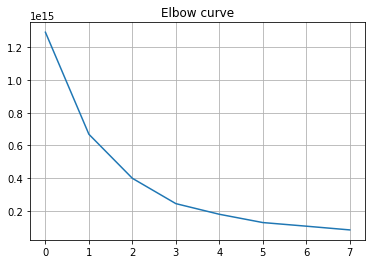

In [15]:
elbow=[]
for i in tqdm( range(2,10)):
    km =KMeans(n_clusters=int(i), init='k-means++', tol=0.0001).fit(Information_cluster.values)
    elbow.append(km.inertia_)
plt.plot(elbow)
plt.grid(True)
plt.title('Elbow curve')
plt.show()



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [46:30<00:00, 155.01s/it]


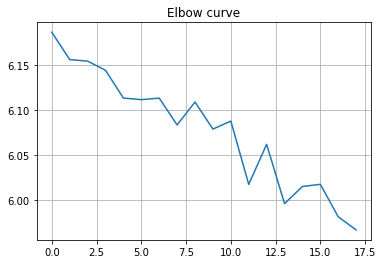

In [20]:
elbow1=[]
for i in tqdm( range(2,20)):
    km1 =KMeans(n_clusters=int(i), init='k-means++', tol=0.0001).fit(Description_cluster.values)
    elbow1.append(km1.inertia_)
plt.plot(elbow1)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [39]:
with open(r'C:\Users\Daniele\Desktop\liste download\DESC_clus', 'wb') as f:
    pickle.dump(km1,f)
    
with open(r'C:\Users\Daniele\Desktop\liste download\INF_clus', 'wb') as f:
    pickle.dump(km,f)    

After see the result of the plot we have hired that we can set 3 clusters for the Information matrix. For Description matrix we don't have a perfect elbow and we choose as most meaningfull  

In [46]:
# Using sklearn to compute KMeans++
km =KMeans(n_clusters=7, init='k-means++', tol=0.0001).fit(Description_cluster)
km1=KMeans(n_clusters=3, init='k-means++', tol=0.0001).fit(Information_cluster)
# Get cluster assignment labels
labels = km.labels_
labels1 = km1.labels_

In order to see which pair of clusters are the most similar we compute the $Jaccard-similarity$, also known as Intersection over union. We have defined a simple function and and subsequently it was applied to the clusters outputs.

In [47]:
def jaccard(a, b):
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [50]:
#initialize empty dictionary with the size of clusters
d={k:[] for k in range(7)}
d1={k:[] for k in range(3)}

for i,v in enumerate(labels):
    d[v].append(i)
    
for i,v in enumerate(labels1):
    d1[v].append(i)
    
sim=[]
for i,cluster1 in enumerate(d.values()):
    for j,cluster2 in enumerate(d1.values()):
        similarity = jaccard(set(cluster1),set(cluster2))
        sim.append([similarity,i,j])
        print('Jaccard similarity of Description cluster {0} with Information cluster {1}: {2}'.format(i,j,similarity))

Jaccard similarity of Description cluster 0 with Information cluster 0: 0.0011940298507462687
Jaccard similarity of Description cluster 0 with Information cluster 1: 0.0
Jaccard similarity of Description cluster 0 with Information cluster 2: 0.001145475372279496
Jaccard similarity of Description cluster 1 with Information cluster 0: 0.04015505416956565
Jaccard similarity of Description cluster 1 with Information cluster 1: 0.0
Jaccard similarity of Description cluster 1 with Information cluster 2: 0.009486166007905139
Jaccard similarity of Description cluster 2 with Information cluster 0: 0.00029853716787740076
Jaccard similarity of Description cluster 2 with Information cluster 1: 0.0
Jaccard similarity of Description cluster 2 with Information cluster 2: 0.0
Jaccard similarity of Description cluster 3 with Information cluster 0: 0.0015921982286794705
Jaccard similarity of Description cluster 3 with Information cluster 1: 0.0
Jaccard similarity of Description cluster 3 with Informatio

In [51]:
#sort sim list in order to have the 3 most similiar
sim.sort(reverse=True)
sim[:3]
#store in a dataframe
Most_relevant=pd.DataFrame(sim[:3])
Most_relevant.rename(columns={0:'Most Similar',1:'Description Cluster',2:'Information Cluster'}, inplace=True)
Most_relevant

,Most Similar,Description Cluster,Information Cluster
0,0.676985,6,0
1,0.214042,4,0
2,0.080293,6,2


## CREATE IMAGE WORDCLOUD

In [28]:
#list of words to be filterd by wordcloud
filtered_cloud = [i for i in stopwords.words('italian')]

In [29]:
stopwords = set()
stopwords.update(filtered_cloud)

All words from announcements in every couple of clusters(only the 3 most similar) are stored in two lists, after this the lists are merged and then converted to a single text. A custom figure is processed for every wordcloud and then the plots are showed all together

In [52]:
#1° cluster pair
#take the words of announcement from Description cluster
Word_cloud1=[]
for i in desc:
    if (desc.index(i) in d[6])==True:
        Word_cloud1.append(i)
#take the words of announcement from Information cluster
Word_cloud2=[]
for j in desc:
    if (desc.index(j) in d1[0])==True:
        Word_cloud2.append(j)
#merge the lists from both cluters
f=Word_cloud1+Word_cloud2 
#creation of a big text
text1 = " ".join(review for review in f)

#creation of custom image shape
cloud1 = np.array(Image.open(r'C:\Users\Daniele\Desktop\nuvola.jpg'))
cloud1[cloud1 > 252] = 255
wc = WordCloud(background_color="white", max_words=9000, mask=cloud1,
           stopwords=stopwords, contour_width=1, contour_color='white')

#2° cluster pair
Word_cloud3=[]
for i in desc:
    if (desc.index(i) in d[4])==True:
        Word_cloud3.append(i)

Word_cloud4=[]
for j in desc:
    if (desc.index(j) in d1[0])==True:
        Word_cloud4.append(j)

f=Word_cloud3+Word_cloud4 

text2 = " ".join(review for review in f)

cloud2 = np.array(Image.open(r'C:\Users\Daniele\Desktop\nuvola.jpg'))
cloud2[cloud2 > 252] = 255
wc = WordCloud(background_color="white", max_words=9000, mask=cloud2,
           stopwords=stopwords, contour_width=1, contour_color='white')


#3° cluster pair
Word_cloud5=[]
for i in desc:
    if (desc.index(i) in d[6])==True:
        Word_cloud5.append(i)

Word_cloud6=[]
for j in desc:
    if (desc.index(j) in d1[2])==True:
        Word_cloud6.append(j)

f=Word_cloud5+Word_cloud6 

text3 = " ".join(review for review in f)

cloud3 = np.array(Image.open(r'C:\Users\Daniele\Desktop\nuvola.jpg'))
cloud3[cloud3 > 252] = 255
wc = WordCloud(background_color="white", max_words=9000, mask=cloud3,
           stopwords=stopwords, contour_width=1, contour_color='white')

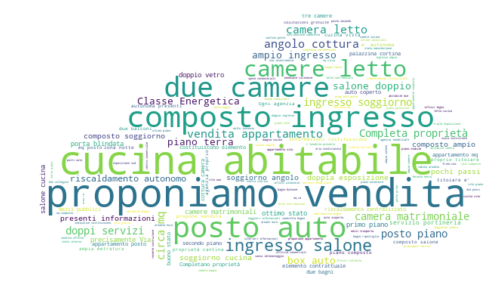

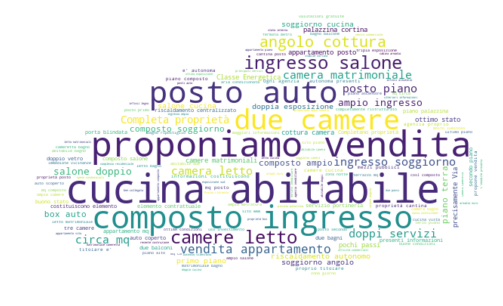

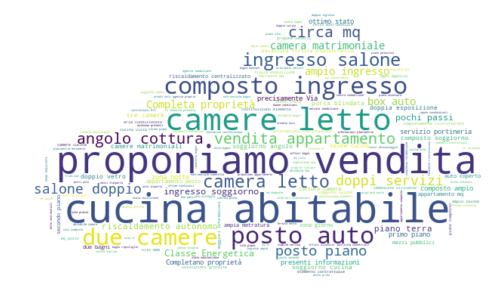

In [53]:
wc.generate(text1)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.generate(text2)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.generate(text3)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Hashing

## Hashing without order

We use hashing by multiplication, but before hashing we use two methods for converting a password to a numerical value.
For the first case it does not account for order of the letter in case there are duplicates of the same letter, so all the duplicates will get the same value. By contrast the later method pays attension for the order of the letter. so the later method for sure it produces a unique value for each unique input of password.

In [5]:
# read passwords

# try to use encoding and check the results ', encoding = 'ascii''
passwords = pd.read_csv('/Users/hesham/Data Science/Algorithmic methods of Data Mining/HW04/passwords2.txt', sep = ' ', header=None)


In [6]:
passwords.head()

,0
0,"OHcv-/U3QI$rdqYTef""D"
1,"QtA*.xM$e(+""aO36r&Uo"
2,T;rqw/ou'HN-Pklj6hM*
3,"b%xJ79""A*C5@ehMfS3lu"
4,"buI=;LpjBiCm""JS5'#xy"


In [7]:
# function for converting a password to a value
def convert(password):
    values = 1
    values_string = [ ord(x) for x in password ]
    for num in values_string:
        #print("values = ", values, " number = ", num)
        values += num**2
    return values

In [8]:
passwords.columns = ['password']
# compute the value for each password
passwords['value'] = passwords['password'].apply(convert)

In [9]:
# checking the maximum value for using the hash
print("max = ", passwords['value'].max())

max =  6939316


### Hash function

In our function:
m = the size of the desired hash table(number of items).
A = a constant used for multiplication

For computing the number of flase positives. We already know that we have duplicate passwords of 10M. So we should expect to see at least 10M collisions of hash keys. 
number_of_false_positives = number_of_collesions - 10M.

In [17]:
# hash by multiplication
# as the maximum number generated from converting password to number is 6939316 

# for counting duplicates
hash_dict = {}
def pass_hash(k):
    # applying this formula - h(k) = floor(m * (kA - floor(kA)))
    # A = (sqrt(5)-1)/2 
    A = (math.sqrt(5) - 1) / 2
    # I choose m = 7996369 for without order case, 
    # for with order case, 1111111111111734917783147409739066433631150937867290
    m = 1111111111111734917783147409739066433631150937867291
    result = 0
    # calculation
    ka = k * A
    result = math.floor(m * (ka - math.floor(ka)))
    # string result for building the dictionary
    string_key = str(result)
    if string_key in hash_dict:
        hash_dict[string_key] += 1
    else:
        hash_dict[string_key] = 1
    return result

In [13]:
# apply hashing
passwords['hash_value'] = passwords['value'].apply(pass_hash)

In [14]:
# count Number of duplicates
duplicates = sum(value for value in hash_dict.values() if value > 1)

# false positives
# as we already know there are 10M duplicates we must get 10M duplicates of hash values, so
# false positive = number of duplicates resulted from hashing - number of duplicates before hashing

false_positives = duplicates - 10000000

print("Number of false positives : ", false_positives)



Number of false positives :  94360839


## Consedering the order

In [15]:
# function for converting a password to a value
def convert_order(password):
    values = 1
    dict_letters = dict()
    for letter in password:
        if letter in dict_letters:
            dict_letters[letter] += 1
        else :
            dict_letters[letter] = 1
        # calculate the value of the letter and add it to the values
        values += ord(letter)**dict_letters[letter]
    return values

In [16]:
# compute the value for each password
passwords['value_order'] = passwords['password'].apply(convert_order)
# check the max value of converted password
print("max = ", passwords['value_order'].max())


max =  1111111111111734917783147409739066433631150937867290


In [18]:
hash_dict = {}
# also change the value of m in hash function to, 1111111111111734917783147409739066433631150937867291
# apply hashing
passwords['hash_value_order'] = passwords['value_order'].apply(pass_hash)

In [19]:
# count Number of duplicates
duplicates = sum(value for value in hash_dict.values() if value > 1)

# false positives
# as we already know there are 10M duplicates we must get 10M duplicates of hash values, so
# false positive = number of duplicates resulted from hashing - number of duplicates before hashing

false_positives02 = duplicates - 10000000

print("Number of false positives : ", false_positives)

Number of false positives :  94360839
